In [1]:
# imports
import shap 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from datetime import datetime, timedelta
import pickle
import matplotlib.dates as mdates
import plotly.graph_objects as go
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

import tensorflow as tf    
# tf.compat.v1.disable_v2_behavior() 




import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
# from tensorflow.python.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dense, LSTM

from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2024-01-13 13:47:05.908196: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 13:47:06.530865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 13:47:06.531156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-13 13:47:06.633393: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-13 13:47:06.856808: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda

SHAP version is: 0.44.0
Tensorflow version is: 2.15.0
Num GPUs Available:  0


### Load Dataset and tools

In [2]:
import pickle

# Datasets
with open('./LSTM_Dataset_&_tools/X_train_list.pkl', 'rb') as file:
    X_train_list = pickle.load(file)

with open('./LSTM_Dataset_&_tools/Y_train.pkl', 'rb') as file:
    Y_train = pickle.load(file)

# Load the i2M2_df DataFrame
with open(f"../cleaned_data/2022/i2M2_df.pkl", 'rb') as file:
    i2M2_df = pickle.load(file)



# Tools
with open('./LSTM_Dataset_&_tools/Y_train_scalers.pkl', 'rb') as file:
    Y_train_scalers = pickle.load(file)

with open('./LSTM_Dataset_&_tools/station_list_for_dataset.pkl', 'rb') as file:
    station_list_for_dataset = pickle.load(file)

with open('./LSTM_Dataset_&_tools/index_list_for_dataset.pkl', 'rb') as file:
    index_list_for_dataset = pickle.load(file)

with open('./LSTM_Dataset_&_tools/index_dict_by_parameter.pkl', 'rb') as file:
    dict_station_to_list_index_param = pickle.load(file)

with open('./LSTM_Dataset_&_tools/index_dict_by_station.pkl', 'rb') as file:
    dict_station_to_list_index_param = pickle.load(file) # Check if this is the correct variable

with open('./LSTM_Dataset_&_tools/features_name.pkl', 'rb') as f:
    features_name = pickle.load(f)

with open('./LSTM_Dataset_&_tools/list_fraction_param.pkl', 'rb') as f:
    list_fraction_param = pickle.load(f)

with open('./LSTM_Dataset_&_tools/max_param_dict.pkl', 'rb') as f:
    max_param_dict = pickle.load(f)

with open('./LSTM_Dataset_&_tools/index_dict_by_HER.pkl', 'rb') as f:
    index_dict_by_HER = pickle.load(f)

with open('./LSTM_Dataset_&_tools/HER_to_HER_id_dict.pkl', 'rb') as f:
    HER_to_HER_id_dict = pickle.load(f)

with open('./LSTM_Dataset_&_tools/HER_id_to_HER_dict.pkl', 'rb') as f:
    HER_id_to_HER_dict = pickle.load(f)

with open('./LSTM_Dataset_&_tools/median_dict_param.pkl', 'rb') as f:
    median_dict_param = pickle.load(f)

with open('./LSTM_Dataset_&_tools/IQR_dict_param.pkl', 'rb') as f:
    IQR_dict_param = pickle.load(f)



## Define Hyperparameters and global variables

In [3]:
# Hyperparameters

# indice
idx_dataset_test = 0

# number of features
features = len(features_name)

# learning rate
learning_rate = 0.001

#look back
look_back = 1

#Nombre d'époch
nb_epoch = 2

In [4]:
# reshape to fit the LSTM model input layer shape

reshaped_X_train_list = []
# Loop through each element in X_train_list
for x in X_train_list:
    # Convert the element to a NumPy array with dtype float32
    np_array_x = np.array(x, dtype=np.float64)
    
    # Reshape the array
    reshaped_array_x = np_array_x.reshape((np_array_x.shape[0], look_back, features))
    
    # Append the reshaped array to the new list
    reshaped_X_train_list.append(reshaped_array_x)

# Now reshaped_X_train_list contains the reshaped arrays
X_train_list = reshaped_X_train_list

In [5]:
print(len(X_train_list))
print(len(Y_train))

6896
6896


In [6]:
print(X_train_list[0].shape)


(9, 1, 16)


### Definition et entrainement du modele

In [7]:
# Define the LSTM model
# model = tf.keras.models.Sequential()

# # model.add(tf.keras.layers.LSTM(50, input_shape=(look_back, features)))
# model.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(look_back, features)))  # Set return_sequences=True
# model.add(tf.keras.layers.LSTM(32))  # Last LSTM layer can output 2D tensor
# model.add(tf.keras.layers.Dropout(0.2))
        
# model.add(tf.keras.layers.Dense(1))

# optimizer = tf.keras.optimizers.Adam(learning_rate)

# # model.compile(loss='mean_squared_error', optimizer='adam')
# model.compile(loss='mean_squared_error', optimizer=optimizer)



# Define the LSTM model
model = tf.keras.models.Sequential()

# First LSTM layer with more units and return_sequences set to True
model.add(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(look_back, features)))

# Additional LSTM layer
model.add(tf.keras.layers.LSTM(64, return_sequences=True))

# Last LSTM layer with return_sequences set to False
model.add(tf.keras.layers.LSTM(32))

# Dropout layer after LSTM layers
model.add(tf.keras.layers.Dropout(0.3))

# Additional Dense layer
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Another Dropout layer
model.add(tf.keras.layers.Dropout(0.3))

# Final Dense layer with one unit for regression output
model.add(tf.keras.layers.Dense(1))

# Optimizer with a learning rate parameter
optimizer = tf.keras.optimizers.Adam(learning_rate)
# Compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)
# model.compile(loss='mean_squared_error', optimizer='adam')



In [8]:
#fonctionne pas encore, on a pas forcément besoin pour l'instant
#define early stopping (currently unused and not working)
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


In [9]:
# Train the model

training_sets = [(X_train_list[i], Y_train[i]) for i in range(0, len(X_train_list))]                

dataset_test = training_sets.pop(idx_dataset_test)



# Train_loss = []
# validation_loss = []

# # Define the callback
# terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()

# for _ in range(nb_epoch):
#     random.shuffle(training_sets)  # Shuffle the training sets order
#     Loss = []  
#     it = 0
#     for X, y in tqdm(training_sets, desc="Training Progress"):
#         history = model.fit(X, y, validation_data=(X_train_list[1], Y_train[1]), epochs=1, verbose=0)
#         Loss.extend(history.history['loss'])
#         it += 1

#     loss = sum(Loss)/len(Loss)
#     Train_loss.append(loss)

    

#     # Assuming validation loss should be recorded per epoch
#     validation_loss.append(history.history['val_loss'][-1])  # Record the last validation loss of the epoch

#     # print("validation_loss = ", validation_loss[-1])

# epoch_train_loss_list = []
# batch_train_loss_list = []

# plot_batch_train_loss_list = []
# plot_batch_validation_loss_list = []

# epoch_validation_loss = []

# # Define the callback
# terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()
# it = 0
# for epoch in range(nb_epoch):
#     random.shuffle(training_sets)  # Shuffle the training sets order
#     epoch_loss = []  # Reset the loss for the epoch
    
#     for X, y in tqdm(training_sets, desc=f"Epoch {epoch+1}/{nb_epoch} Training Progress"):
        
#         history = model.fit(X, y, validation_data=(X_train_list[1], Y_train[1]), epochs=1, verbose=2, callbacks=[terminate_on_nan])
#         batch_train_loss_list.extend(history.history['loss'])
        
#         if it % 1000: 
#             plot_batch_train_loss_list.append(history.history['loss'][0])  
#             plot_batch_validation_loss_list.append(history.history['val_loss'][0])

#         it+=1

#     epoch_train_loss = sum(batch_train_loss_list)/len(batch_train_loss_list)
#     epoch_train_loss_list.append(epoch_train_loss)

#     # Assuming validation loss should be recorded per epoch
#     epoch_validation_loss.append(history.history['val_loss'][-1]) 


# model.save('my_model.keras')

In [10]:
epoch_train_loss_list = []
batch_train_loss_list = []

plot_batch_train_loss_list = []
plot_batch_validation_loss_list = []

epoch_validation_loss = []

# Define the callback
terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()

it = 0  # Iteration counter
for epoch in range(nb_epoch):
    random.shuffle(training_sets)  # Shuffle the training sets order
    epoch_loss = []  # Reset the loss for the epoch

    for X, y in tqdm(training_sets, desc=f"Epoch {epoch+1}/{nb_epoch} Training Progress"):
        history = model.fit(X, y, validation_data=(X_train_list[1], Y_train[1]), epochs=1, verbose=0, callbacks=[terminate_on_nan])
        current_loss = history.history['loss'][0]
        epoch_loss.append(current_loss)
        batch_train_loss_list.append(current_loss)  # Collect loss for each batch
        
        if it % 1000 == 0 and it != 0: 
            # Store loss every 1000 iterations
            plot_batch_train_loss_list.append(current_loss)
            plot_batch_validation_loss_list.append(history.history['val_loss'][0])

        it += 1

    # Compute average loss for the epoch
    epoch_train_loss = sum(epoch_loss) / len(epoch_loss)
    epoch_train_loss_list.append(epoch_train_loss)

    # Store validation loss at the end of each epoch
    epoch_validation_loss.append(history.history['val_loss'][-1])

model.save('my_model.keras')


Epoch 2/2 Training Progress: 100%|██████████| 6895/6895 [16:43<00:00,  6.87it/s]


In [19]:
print("epoch_train_loss_list = ", epoch_train_loss_list)
print("epoch_validation_loss = ", epoch_validation_loss)

epoch_train_loss_list =  [1525.4386917286083, 1470.5526162652257]
epoch_validation_loss =  [1924.5263671875, 1870.6334228515625]


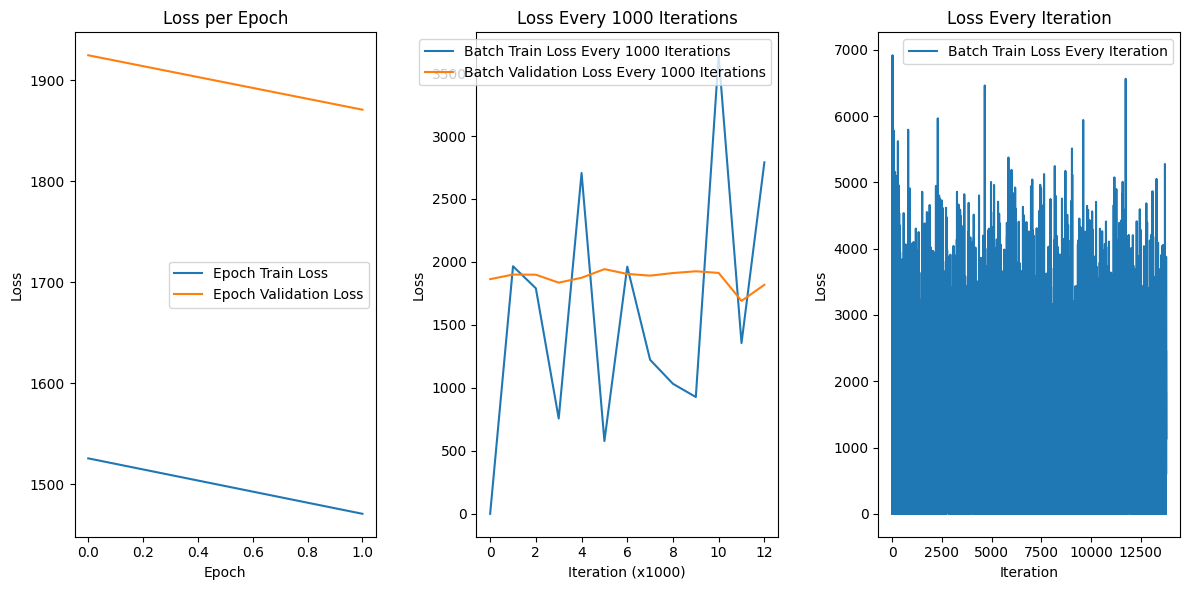

In [30]:
# Plotting
plt.figure(figsize=(12, 6))

# Epoch level loss
plt.subplot(1, 3, 1)
plt.plot(epoch_train_loss_list, label='Epoch Train Loss')
plt.plot(epoch_validation_loss, label='Epoch Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Every 1000 iterations
plt.subplot(1, 3, 2)
plt.plot(plot_batch_train_loss_list, label='Batch Train Loss Every 1000 Iterations')
plt.plot(plot_batch_validation_loss_list, label='Batch Validation Loss Every 1000 Iterations')
plt.title('Loss Every 1000 Iterations')
plt.xlabel('Iteration (x1000)')
plt.ylabel('Loss')
plt.legend()

# Each iteration
plt.subplot(1, 3, 3

)
plt.plot(batch_train_loss_list, label='Batch Train Loss Every Iteration')
plt.title('Loss Every Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
#vizualiize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            74240     
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

### Make prediction and unscale for visualisation

In [22]:
# y_test_unscaled = unscale_true_output(scaler, data10, "String SOH (smoothed)", feature_names, horizon_de_prediction)

X_test = dataset_test[0]
y_test = dataset_test[1]
y_test = y_test / 100

scaler_y_test= Y_train_scalers[idx_dataset_test]


y_test_unscaled = scaler_y_test.inverse_transform(y_test)

y_test_prediction = model.predict(X_test)
y_test_prediction = y_test_prediction / 100









1/1 [==============================] - 0s 276ms/step


In [23]:
print(y_test_prediction.shape)

(9, 1)


In [24]:
y_test_prediction_reshaped = y_test_prediction.reshape(-1, y_test_prediction.shape[1])
y_test_prediction_unscaled = scaler_y_test.inverse_transform(y_test_prediction_reshaped)

In [25]:
# Calculate the root mean squared error
train_score = np.sqrt(mean_squared_error(y_test_unscaled, y_test_prediction_unscaled))

print('Train Score: %.2f RMSE' % (train_score))






Train Score: 0.12 RMSE


### Plot i2M2 predit et réel

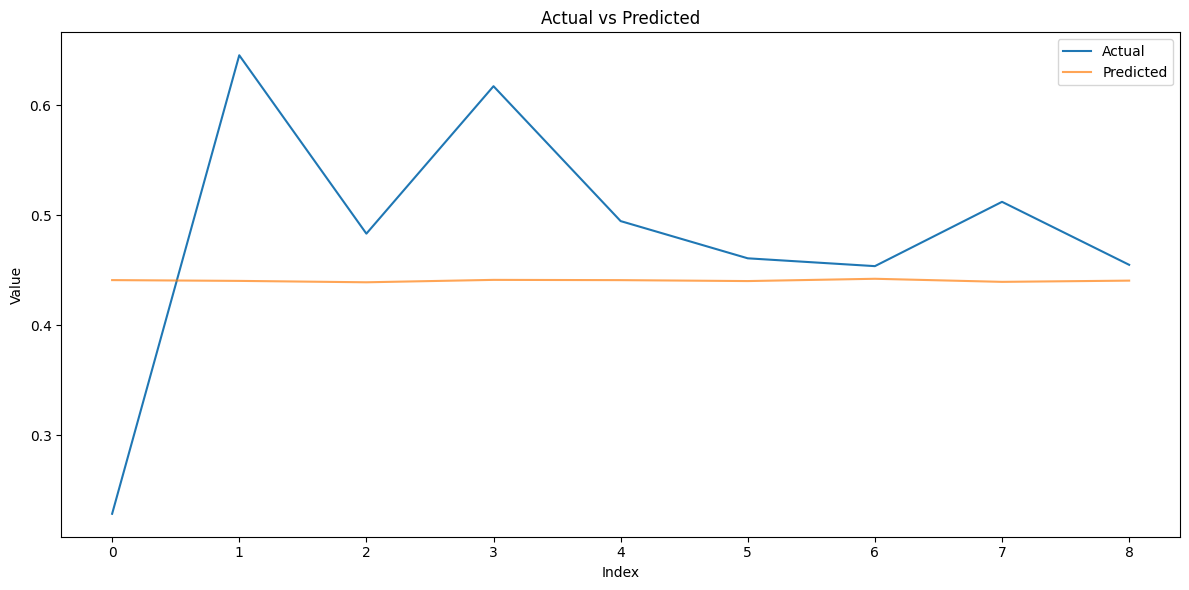

In [27]:


# Ensure dates, y_test_unscaled, and y_test_prediction_unscaled are all 1D arrays of the same length
y_test_unscaled = y_test_unscaled.flatten()
y_test_prediction_unscaled = y_test_prediction_unscaled.flatten()

# Flatten the arrays if they are not already flat
y_test_unscaled = y_test_unscaled.flatten()
y_test_prediction_unscaled = y_test_prediction_unscaled.flatten()

# Create an array of indices corresponding to the length of the test data
indices = range(len(y_test_unscaled))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(indices, y_test_unscaled, label='Actual')
plt.plot(indices, y_test_prediction_unscaled, label='Predicted', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()


# if(only_soh):
#     # Define the file path and name
#     file_path = './graphs/perf graph/RMSE_comp_soh/lissé/soh/Bat_{}_just_soh_soh_{}.png'.format(idx_dataset_test, horizon_de_prediction/jour)
# else:
#     file_path = './graphs/perf graph/RMSE_comp_soh/lissé/soh/Bat_{}_full_feature_soh_{}.png'.format(idx_dataset_test, horizon_de_prediction/jour)

# Create the directory if it does not exist
# directory = os.path.dirname(file_path)
# if not os.path.exists(directory):
#     os.makedirs(directory)

   






plt.show()


### Shapley values

In [ ]:
# Test shap 1
shap.initjs()

size_background = 100
backgroud_distance_to_explained_input = 1000

# !!!!!!! explained_input_idx must be > size_background && < len(X_traini[0]) !!!!!!!
explained_input_idx = size_background + backgroud_distance_to_explained_input

# select a set of background examples to take an expectation over
#background = X_train5[explained_input_idx - backgroud_distance_to_explained_input - size_background : explained_input_idx - backgroud_distance_to_explained_input]
# background = X_train10[np.random.choice(X_train10.shape[0], size_background, replace=False)]
# background = X_train10[explained_input_idx-size_background:explained_input_idx]
background = X_test[0:100]


# print(background.shape)

#print(X_train5[explained_input_idx - backgroud_distance_to_explained_input - size_background : explained_input_idx - backgroud_distance_to_explained_input].shape)


In [ ]:
explainer = shap.DeepExplainer(
    (model.layers[0].input, model.layers[-1].output), background
)

# Are computed the shaplay value of the explained input and of the next input
#shap_values = explainer.shap_values(X_train5[explained_input_idx : X_train5.shape[0]]) 
shap_values = explainer.shap_values(X_test[0 : X_test.shape[0]]) 

# shap_values_list = shap_values[0]




Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    File "/home/orfeu/Documents/cours/3A/Cours_d_eau/Projet-cours-d-eau/Projet-cours-d-eau/.venv/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 247, in grad_graph  *
        out = self.model(shap_rAnD)
    File "/home/orfeu/Documents/cours/3A/Cours_d_eau/Projet-cours-d-eau/Projet-cours-d-eau/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/orfeu/Documents/cours/3A/Cours_d_eau/Projet-cours-d-eau/Projet-cours-d-eau/.venv/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 370, in custom_grad
        out = op_handlers[type_name](self, op, *grads) # we cut off the shap_ prefix before the lookup
    File "/home/orfeu/Documents/cours/3A/Cours_d_eau/Projet-cours-d-eau/Projet-cours-d-eau/.venv/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 662, in handler
        return linearity_with_excluded_handler(input_inds, explainer, op, *grads)
    File "/home/orfeu/Documents/cours/3A/Cours_d_eau/Projet-cours-d-eau/Projet-cours-d-eau/.venv/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 669, in linearity_with_excluded_handler
        assert not explainer._variable_inputs(op)[i], str(i) + "th input to " + op.name + " cannot vary!"
    File "/home/orfeu/Documents/cours/3A/Cours_d_eau/Projet-cours-d-eau/Projet-cours-d-eau/.venv/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 224, in _variable_inputs
        out[i] = t.name in self.between_tensors

    AttributeError: Exception encountered when calling layer 'lstm' (type LSTM).
    
    'TFDeep' object has no attribute 'between_tensors'
    
    Call arguments received by layer 'lstm' (type LSTM):
      • inputs=tf.Tensor(shape=(18, 1, 16), dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [ ]:
print("shape shap_values:", shap_values[0])

shape shap_values: [[[-3.61127257e-07 -6.03209951e-07  5.67358409e-05  1.60547648e-04
   -4.86084726e-06  1.85226105e-03]
  [-8.58857852e-06 -3.50581690e-06  2.29913759e-04  1.62550174e-04
   -2.40493740e-05  2.45308039e-03]
  [-1.64040675e-05 -7.05326866e-06  2.97289432e-04  1.63473976e-04
   -3.30494903e-05  2.90243359e-03]
  [-1.09266120e-05 -1.22838969e-05  2.40086140e-04  1.98925048e-04
   -3.73321748e-05  2.95932292e-03]
  [-1.65213049e-05 -1.96091364e-05  1.06152266e-04  3.00829659e-04
   -6.66907546e-05  2.29016025e-03]]

 [[-3.24298815e-07 -6.34719629e-07  4.79951873e-05  1.60363588e-04
   -5.02437702e-06  1.81509103e-03]
  [-8.02787806e-06 -3.58951684e-06  1.69222782e-04  1.62406112e-04
   -2.42754992e-05  2.40446281e-03]
  [-1.58494098e-05 -7.17312229e-06  1.88706138e-04  1.63408437e-04
   -3.32149351e-05  2.84565605e-03]
  [-1.95959600e-05 -1.24435792e-05  1.04341713e-04  1.98937551e-04
   -3.73810099e-05  2.90490927e-03]
  [-1.65105005e-05 -1.97475988e-05 -3.21681839e-05  

In [ ]:
# Unscale the shapley values

min_val = scaler_y_test.data_min_  # The minimum value of the original data
max_val = scaler_y_test.data_max_  # The maximum value of the original data
scale_val = max_val-min_val  # The scale factor used by the MinMaxScaler

# Initialize an empty array with the same shape
unscaled_shap_values = np.empty_like(shap_values[0])

# Iterate through the array and unscale each element
for i in range(shap_values[0].shape[0]):  # Iterate over the first dimension
    for j in range(shap_values[0].shape[1]):  # Iterate over the second dimension
        for k in range(shap_values[0].shape[2]):  # Iterate over the third dimension
            # Reshape the value to 2D, unscale and flatten back to 1D
            # Pour avoir les bonnes valeurs de shapley unscaled, il faut reshape en 2D, unscale puis re-flatten en 1D, puis diviser par le facteur d'échelle pour corriger le biai du scaler
            # unscaled_shap_values[i, j, k] = scaler_y10.inverse_transform(shap_values[0][i, j, k].reshape(-1, 1)).flatten()

            # unscaled_shap_values[i, j, k] = (shap_values[0][i, j, k] * scale_val) + min_val

            # On a juste à unscale les shap_value par le même facteur d'echelle que les y (on opère pas le décallage sur les valeurs de shapley, ça a pas de sens)
            unscaled_shap_values[i, j, k] = shap_values[0][i, j, k]/scale_val

            # if(unscaled_shap_values[i, j, k]>=0):
            #     unscaled_shap_values[i, j, k] = scaler_y10.inverse_transform(shap_values[0][i, j, k].reshape(-1, 1)).flatten()*scaler_y10.scale_-scaler_y10.min_
                
            # else:
            #     unscaled_shap_values[i, j, k] = -scaler_y10.inverse_transform(-shap_values[0][i, j, k].reshape(-1, 1)).flatten()*scaler_y10.scale_-scaler_y10.min_

            # unscaled_shap_values[i, j, k] = shap_values[0][i, j, k]*scaler_y10.scale_+scaler_y10.min_
            

shap_values[0] = unscaled_shap_values

In [ ]:
print("shap_values shape:", shap_values[0].shape)
# print("shape_values type: ", type(shap_values))
# print("shape_values[1]", shap_values[0])

shap_values shape: (14729, 5, 6)


In [ ]:
print(shap_values[0])

[[[-1.33794684e-07 -2.23484335e-07  2.10201633e-05  5.94815857e-05
   -1.80090401e-06  6.86247516e-04]
  [-3.18199784e-06 -1.29887638e-06  8.51811603e-05  6.02235052e-05
   -8.91009567e-06  9.08846149e-04]
  [-6.07757236e-06 -2.61317814e-06  1.10143294e-04  6.05657664e-05
   -1.22445649e-05  1.07532782e-03]
  [-4.04822005e-06 -4.55108295e-06  8.89499441e-05  7.37000973e-05
   -1.38312643e-05  1.09640485e-03]
  [-6.12100783e-06 -7.26502408e-06  3.93285433e-05  1.11454919e-04
   -2.47083771e-05  8.48485571e-04]]

 [[-1.20150049e-07 -2.35158412e-07  1.77818229e-05  5.94133930e-05
   -1.86149044e-06  6.72476329e-04]
  [-2.97426292e-06 -1.32988652e-06  6.26956518e-05  6.01701312e-05
   -8.99387317e-06  8.90833735e-04]
  [-5.87207623e-06 -2.65758293e-06  6.99140751e-05  6.05414844e-05
   -1.23058608e-05  1.05429221e-03]
  [-7.26014231e-06 -4.61024396e-06  3.86577482e-05  7.37047298e-05
   -1.38493573e-05  1.07624504e-03]
  [-6.11700489e-06 -7.31632327e-06 -1.19180481e-05  1.11479077e-04
   -

In [ ]:
# print shap plots
 

# Taking the mean per feature across the time steps for the selected input
mean_shap_values_explained_input = np.mean(shap_values[0][0], axis=0)


# Wrap the mean SHAP values in an Explanation object
explanation = shap.Explanation(
    values = mean_shap_values_explained_input,

    base_values = scaler_y_test.inverse_transform(explainer.expected_value[0].reshape(-1, 1)).flatten(),
    # base_values = explainer.expected_value[0]/scaler_y10.scale_+scaler_y10.min_,

    # data = scaler_X10.inverse_transform(X_train10)[explained_input_idx].mean(axis=0),  
    data = X_test[explained_input_idx].mean(axis=0),  
    feature_names = feature_names
)

# Now you can plot with the force_plot function
# shap.force_plot(
#     base_value = scaler_y10.inverse_transform(explainer.expected_value[0].reshape(-1, 1)).flatten(),
#     # base_value = explainer.expected_value[0]/scaler_y10.scale_+scaler_y10.min_,
#     shap_values = explanation.values,  
#     feature_names = feature_names
# )




In [ ]:
#fonctionne pas encore
# visualize all the training set predictions
# shap.plots.force(explainer.expected_value, shap_values[0][:500])

### Shapley value plots

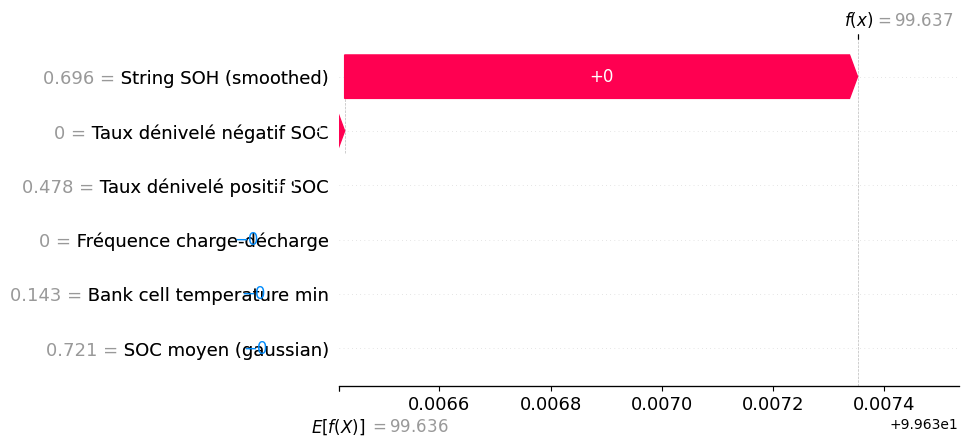

In [ ]:


# Access the current figure
fig = plt.gcf()

# And also use the waterfall_plot function
shap.waterfall_plot(explanation)


if(only_soh):
    # Define the file path and name
    file_path = './graphs/perf graph/RMSE_comp_soh/lissé/exemple_shap_val/Bat_{}_just_soh_{}.png'.format(idx_dataset_test, horizon_de_prediction/jour)
else:
    file_path = './graphs/perf graph/RMSE_comp_soh/lissé/exemple_shap_val/Bat_{}_full_feature_{}.png'.format(idx_dataset_test, horizon_de_prediction/jour)

# Create the directory if it does not exist
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)


# Save the figure
fig.savefig(file_path)

# Optionally, you can display the plot as well
plt.show()

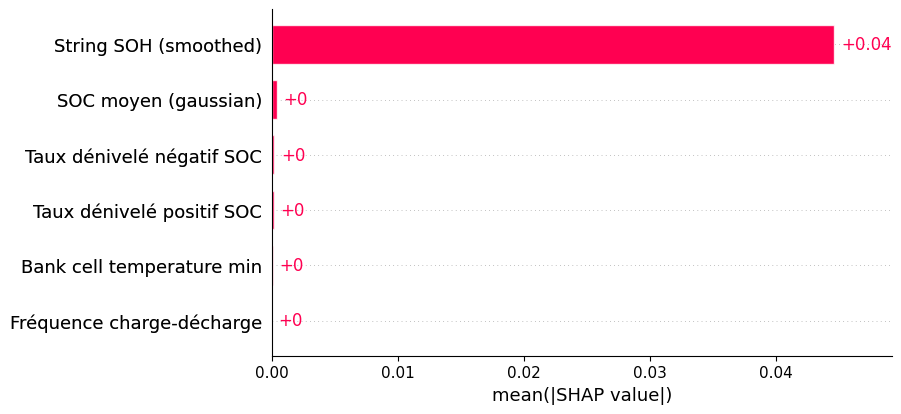

In [ ]:
mean_shap_values_explained_input_all = np.mean(shap_values[0], axis=1)

# Wrap the mean SHAP values in an Explanation object
explanation_bar_plot = shap.Explanation(
    values = mean_shap_values_explained_input_all,

    base_values = scaler_y_test.inverse_transform(explainer.expected_value[0].reshape(-1, 1)).flatten(),
    # base_values = explainer.expected_value[0]/scaler_y10.scale_+scaler_y10.min_,

    # data = scaler_X10.inverse_transform(X_train10).mean(axis=1),  
    data = X_test.mean(axis=1),
    feature_names = feature_names
)




# Access the current figure
fig = plt.gcf()

shap.plots.bar(explanation_bar_plot)


if(only_soh):
    # Define the file path and name
    file_path = './graphs/perf graph/RMSE_comp_soh/lissé/feature_importance/Bat_{}_just_soh_{}.png'.format(idx_dataset_test, horizon_de_prediction/jour)
else:
    file_path = './graphs/perf graph/RMSE_comp_soh/lissé/feature_importance/Bat_{}_full_feature_{}.png'.format(idx_dataset_test, horizon_de_prediction/jour)

# Create the directory if it does not exist
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)


# Save the figure
fig.savefig(file_path)

# Optionally, you can display the plot as well
plt.show()

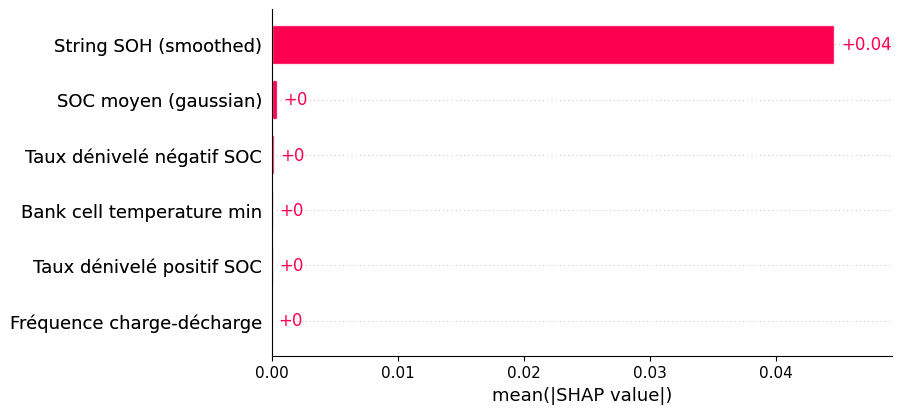

In [ ]:
# Compute the mean of the absolute values of negative SHAP values for each feature
mean_abs_negative_shap_values = np.mean(np.where(shap_values[0] < 0, np.abs(shap_values[0]), 0), axis=1)

# Wrap the mean absolute negative SHAP values in an Explanation object
explanation_bar_plot = shap.Explanation(
    values = mean_abs_negative_shap_values,

    base_values = scaler_y_test.inverse_transform(explainer.expected_value[0].reshape(-1, 1)).flatten(),
    # Uncomment the next line if you want to use the original scaling calculation
    # base_values = explainer.expected_value[0]/scaler_y10.scale_ + scaler_y10.min_,

    data = X_test.mean(axis=1),
    feature_names = feature_names
)



# Access the current figure
fig = plt.gcf()

# Create the SHAP bar plot
shap.plots.bar(explanation_bar_plot)


if(only_soh):
    # Define the file path and name
    file_path = './graphs/perf graph/RMSE_comp_soh/lissé/negative_feature_importance/Bat_{}_just_soh_{}.png'.format(idx_dataset_test, horizon_de_prediction/jour)
else:
    file_path = './graphs/perf graph/RMSE_comp_soh/lissé/negative_feature_importance/Bat_{}_full_feature_{}.png'.format(idx_dataset_test, horizon_de_prediction/jour)

# Create the directory if it does not exist
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)


# Save the figure
fig.savefig(file_path)

# Optionally, you can display the plot as well
plt.show()